In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim

## Data Loading and Exploration

We begin by loading the training and test datasets. Each entry consists of a text sample and its associated emotion label. We then inspect the shape of the datasets, check for missing values, and examine the distribution of labels and text lengths.

In [2]:
def load_dataset(filepath):
    return pd.read_csv(filepath, sep=';', header=None, names=['text', 'label'])

train_df = load_dataset('NLP_exam_emotions_dataset/train.txt')
test_df = load_dataset('NLP_exam_emotions_dataset/test.txt')

In [3]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (16000, 2)
Test shape: (2000, 2)


In [4]:
print("\nSample train data:")
display(train_df.head())


Sample train data:


,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
print("\nMissing values in train set:")
print(train_df.isnull().sum())


Missing values in train set:
text     0
label    0
dtype: int64


In [6]:
print("\nLabel distribution in train set:")
print(train_df['label'].value_counts())


Label distribution in train set:
label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


In [7]:
train_df['text_length'] = train_df['text'].apply(len)
print("\nText length statistics:")
print(train_df['text_length'].describe())


Text length statistics:
count    16000.000000
mean        96.845812
std         55.904953
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
Name: text_length, dtype: float64


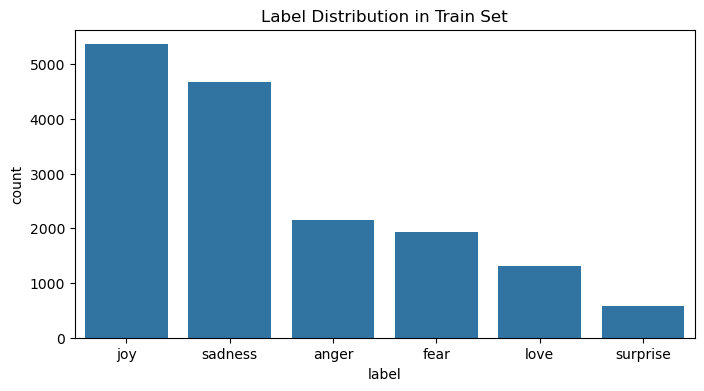

In [8]:
plt.figure(figsize=(8,4))
sns.countplot(data=train_df, x='label', order=train_df['label'].value_counts().index)
plt.title('Label Distribution in Train Set')
plt.show()

## Data Preprocessing

We encode the emotion labels into integers and vectorize the text data using TF-IDF with a maximum of 5000 features. This transforms the text into a numerical format suitable for input to a neural network.

In [9]:
train_df = pd.read_csv('NLP_exam_emotions_dataset/train.txt', sep=';', header=None, names=['text', 'label'])
test_df = pd.read_csv('NLP_exam_emotions_dataset/test.txt', sep=';', header=None, names=['text', 'label'])

le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])
test_df['label_enc'] = le.transform(test_df['label'])

In [10]:
train_df

,text,label,label_enc
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,4
15996,i am now turning and i feel pathetic that i am...,sadness,4
15997,i feel strong and good overall,joy,2
15998,i feel like this was such a rude comment and i...,anger,0


In [11]:
test_df

,text,label,label_enc
0,im feeling rather rotten so im not very ambiti...,sadness,4
1,im updating my blog because i feel shitty,sadness,4
2,i never make her separate from me because i do...,sadness,4
3,i left with my bouquet of red and yellow tulip...,joy,2
4,i was feeling a little vain when i did this one,sadness,4
...,...,...,...
1995,i just keep feeling like someone is being unki...,anger,0
1996,im feeling a little cranky negative after this...,anger,0
1997,i feel that i am useful to my people and that ...,joy,2
1998,im feeling more comfortable with derby i feel ...,joy,2


In [32]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['text']).toarray()
X_test = vectorizer.transform(test_df['text']).toarray()
y_train = train_df['label_enc'].values
y_test = test_df['label_enc'].values

## Dataset and DataLoader

We define a custom PyTorch Dataset to wrap our features and labels, and use DataLoader to efficiently batch and shuffle the data for training and evaluation.

In [33]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))  # Should print your GPU name

True
NVIDIA GeForce RTX 4060 Laptop GPU


## Model Definition

We define a Fully Connected Neural Network (FCNN) with two hidden layers and ReLU activations. The model takes the TF-IDF features as input and outputs class scores for each emotion.

In [34]:
class FCNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

## Training Setup

We set up the training process by specifying the device (CPU or GPU), loss function (cross-entropy), optimizer (Adam), and number of epochs.

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCNN(X_train.shape[1], len(le.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20

## Model Summary

We display a summary of the model architecture, including the number of parameters and the shape of each layer.

In [17]:
summary(model, input_size=(32, X_train.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
FCNN                                     [32, 6]                   --
├─Linear: 1-1                            [32, 256]                 1,280,256
├─ReLU: 1-2                              [32, 256]                 --
├─Linear: 1-3                            [32, 128]                 32,896
├─ReLU: 1-4                              [32, 128]                 --
├─Linear: 1-5                            [32, 6]                   774
Total params: 1,313,926
Trainable params: 1,313,926
Non-trainable params: 0
Total mult-adds (M): 42.05
Input size (MB): 0.64
Forward/backward pass size (MB): 0.10
Params size (MB): 5.26
Estimated Total Size (MB): 6.00

In [23]:
training_args = {
    'num_epochs': 40,
    'batch_size': 256,
    'learning_rate': 3e-5,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

## Training Function

We implement a training loop that tracks loss and accuracy for both training and validation sets. The best model (based on validation accuracy) is saved for later evaluation.

In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_running_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()
        epoch_val_loss = val_running_loss / val_total
        epoch_val_acc = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict()

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    # After training, load and save the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        torch.save(model.state_dict(), 'best_fcnn_model.pth')
        print(f"Best model saved with validation accuracy: {best_val_acc:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [25]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.tight_layout()
    plt.show()

In [26]:
model = FCNN(X_train.shape[1], len(le.classes_)).to(training_args['device'])
optimizer = optim.Adam(model.parameters(), lr=training_args['learning_rate'], weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, training_args['num_epochs'], training_args['device']
)

Epoch 1/40 | Train Loss: 1.7741, Train Acc: 0.2484 | Val Loss: 1.6924, Val Acc: 0.2905
Epoch 2/40 | Train Loss: 1.6019, Train Acc: 0.3355 | Val Loss: 1.5384, Val Acc: 0.3475
Epoch 3/40 | Train Loss: 1.5335, Train Acc: 0.3352 | Val Loss: 1.5047, Val Acc: 0.3490
Epoch 4/40 | Train Loss: 1.4908, Train Acc: 0.3678 | Val Loss: 1.4585, Val Acc: 0.4040
Epoch 5/40 | Train Loss: 1.4228, Train Acc: 0.4839 | Val Loss: 1.3813, Val Acc: 0.5220
Epoch 6/40 | Train Loss: 1.3135, Train Acc: 0.5659 | Val Loss: 1.2648, Val Acc: 0.5840
Epoch 7/40 | Train Loss: 1.1674, Train Acc: 0.6202 | Val Loss: 1.1264, Val Acc: 0.6340
Epoch 8/40 | Train Loss: 1.0173, Train Acc: 0.6829 | Val Loss: 0.9990, Val Acc: 0.6830
Epoch 9/40 | Train Loss: 0.8885, Train Acc: 0.7433 | Val Loss: 0.8948, Val Acc: 0.7335
Epoch 10/40 | Train Loss: 0.7841, Train Acc: 0.7877 | Val Loss: 0.8115, Val Acc: 0.7690
Epoch 11/40 | Train Loss: 0.6990, Train Acc: 0.8174 | Val Loss: 0.7442, Val Acc: 0.7970
Epoch 12/40 | Train Loss: 0.6264, Train A

## Results and Evaluation

After training, we plot the loss and accuracy curves for both training and validation sets to visualize the learning process and check for overfitting or underfitting.

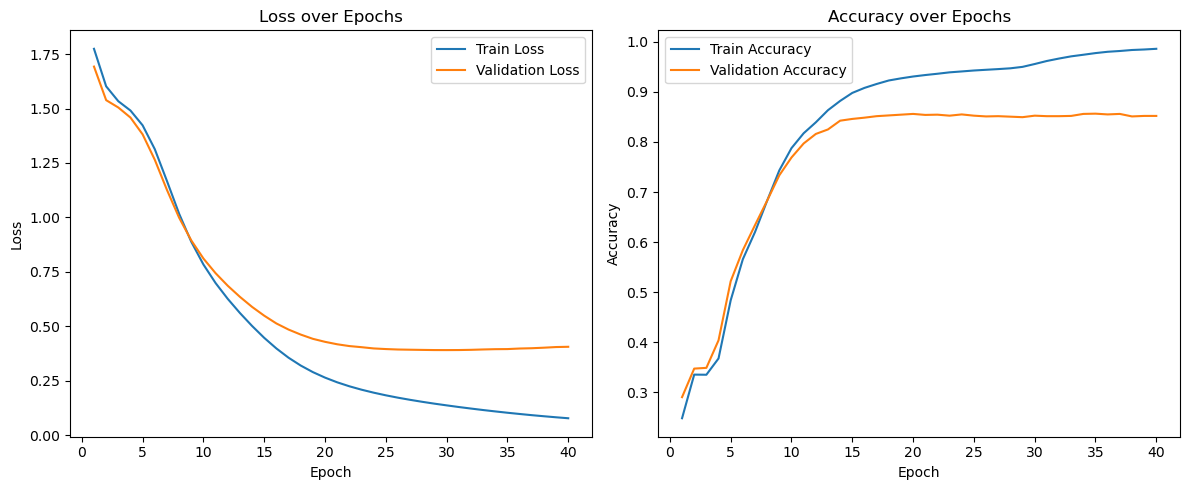

In [27]:
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

## Training and Validation Curves

The plots above display the loss and accuracy for both the training and validation sets over 100 epochs.

- **Loss over Epochs (Left Plot):**
    - Both training and validation loss decrease rapidly at the start, indicating effective learning.
    - Training loss continues to decrease and remains lower than validation loss, which is expected.
    - Validation loss plateaus after a certain point, suggesting the model has reached its optimal generalization.

- **Accuracy over Epochs (Right Plot):**
    - Both training and validation accuracy increase quickly during the initial epochs.
    - Training accuracy continues to improve and approaches 1.0, while validation accuracy plateaus at a high value.
    - The gap between training and validation accuracy is reasonable and stable, indicating no severe overfitting.

**Conclusion:**  
These curves suggest that the model is learning well and generalizing effectively to the validation set. There is no sign of underfitting or severe overfitting. Further improvements could be explored by tuning hyperparameters or experimenting with more advanced models.


In [28]:
model.load_state_dict(torch.load('best_fcnn_model.pth'))
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(training_args['device']), y_batch.to(training_args['device'])
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
print(f"Best Model Test Accuracy: {correct/total:.4f}")

C:\Users\Acer\AppData\Local\Temp\ipykernel_31808\1432663221.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_fcnn_model.pth'))


Best Model Test Accuracy: 0.8520


In [29]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(training_args['device'])
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())

print(classification_report(all_labels, all_preds, target_names=le.classes_))

              precision    recall  f1-score   support

       anger       0.85      0.85      0.85       275
        fear       0.81      0.82      0.81       224
         joy       0.89      0.89      0.89       695
        love       0.67      0.70      0.69       159
     sadness       0.89      0.89      0.89       581
    surprise       0.71      0.52      0.60        66

    accuracy                           0.85      2000
   macro avg       0.80      0.78      0.79      2000
weighted avg       0.85      0.85      0.85      2000



## Confusion Matrix

We compute and display the confusion matrix to analyze the model's performance on each emotion class, identifying which classes are most often confused.

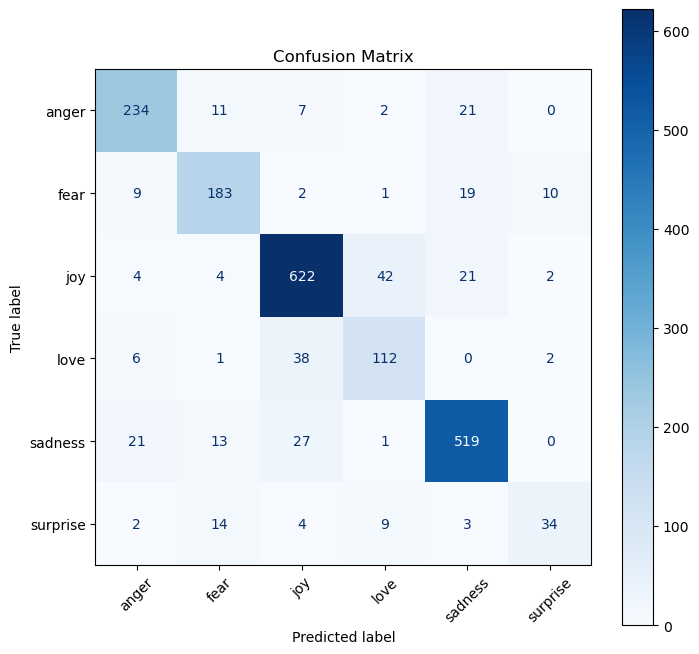

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get all predictions and true labels
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(training_args['device'])
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

## Confusion Matrix Analysis

The confusion matrix above visualizes the performance of the model on the test set, showing the number of correct and incorrect predictions for each emotion class.

- **Diagonal values** represent correct predictions for each class (e.g., 'joy' predicted as 'joy'). Higher values on the diagonal indicate better performance for those classes.
- **Off-diagonal values** indicate misclassifications (e.g., 'love' predicted as 'joy').

### Key Observations
- The model performs very well on the 'joy' and 'sadness' classes, as indicated by the high numbers on the diagonal for these labels.
- The 'love' class is often confused with 'joy', which may be due to similarities in the text or class imbalance.
- The 'surprise' class has the lowest number of samples and is often misclassified as 'fear' or 'joy'.
- Some confusion exists between 'anger' and 'sadness', as well as between 'fear' and 'sadness'.

### Suggestions for Improvement
- **Class Imbalance:** Consider using class weights or data augmentation to help the model better distinguish minority classes like 'surprise' and 'love'.
- **Feature Engineering:** More advanced text features (such as word embeddings or transformer-based models) may help the model better separate similar emotions.
- **Model Tuning:** Experiment with different architectures or regularization techniques to further reduce misclassifications.

**Conclusion:**  
The confusion matrix provides valuable insight into which emotions are most easily confused by the model, guiding future improvements in data processing and model design.